In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import tensorflow as tf
from keras.models import load_model
from sklearn.metrics import (precision_score, recall_score, f1_score, confusion_matrix, hamming_loss)
from keras import backend as K
import matplotlib.ticker as mtick  
from matplotlib.lines import Line2D

seeds = [2,5,7,11,42]

print("GPU disponible:", tf.config.list_logical_devices('GPU'))

# ---------------- Métricas  ----------------
def Accuracy(y_true, y_pred):
    y_pred_rounded = K.round(K.clip(y_pred, 0, 1))
    correct = K.equal(y_true, y_pred_rounded)
    return K.mean(K.cast(correct, K.floatx()))

def Precision(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    tp = K.sum(y_true * y_pred_pos)
    predicted_positives = K.sum(y_pred_pos)
    return tp / (predicted_positives + K.epsilon())

def Specificity(y_true, y_pred):
    y_pred_neg = 1 - K.round(K.clip(y_pred, 0, 1))
    y_true_neg = 1 - y_true
    tn = K.sum(y_true_neg * y_pred_neg)
    possible_negatives = K.sum(y_true_neg)
    return tn / (possible_negatives + K.epsilon())

def Recall(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    tp = K.sum(y_true * y_pred_pos)
    possible_positives = K.sum(y_true)
    return tp / (possible_positives + K.epsilon())

def F1_score(y_true, y_pred):
    prec = Precision(y_true, y_pred)
    rec = Recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec + K.epsilon())

def Hamming_loss(y_true, y_pred):
    mismatches = K.not_equal(K.round(K.clip(y_pred, 0, 1)), y_true)
    return K.mean(K.cast(mismatches, K.floatx()))

GPU disponible: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


### Cargo Historiales

In [2]:
historiales_delta_s2 = {}
historiales_delta_s5 = {}
historiales_delta_s7 = {}
historiales_delta_s11 = {}
historiales_delta_s42 = {}

for SEED in seeds:
    print(f"Semilla: {SEED}")   
    
    # Iteramos de 1 a 5
    for i in range(1, 6):
        # Formateamos el string del path según el valor de i
        path = f"../Modelo V1/Historial Entrenamiento/Semilla {SEED}/historialV1_delta{i}.xlsx"
        if SEED == 2:
            historiales_delta_s2[f"historialV1_delta{i}"] = pd.read_excel(path, header=0)
        elif SEED == 5:
            historiales_delta_s5[f"historialV1_delta{i}"] = pd.read_excel(path, header=0)
        elif SEED == 7:
            historiales_delta_s7[f"historialV1_delta{i}"] = pd.read_excel(path, header=0)
        elif SEED == 11:
            historiales_delta_s11[f"historialV1_delta{i}"] = pd.read_excel(path, header=0)
        elif SEED == 42:
            historiales_delta_s42[f"historialV1_delta{i}"] = pd.read_excel(path, header=0)


path = "../Datos"
datos = []
for dirnames,_,filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('.xlsx'):
            datos.append(os.path.join(dirnames,filename))

print(datos)

Semilla: 2
Semilla: 5
Semilla: 7
Semilla: 11
Semilla: 42
['../Datos\\test.xlsx', '../Datos\\train.xlsx']


### Métricas Entrenamiento:

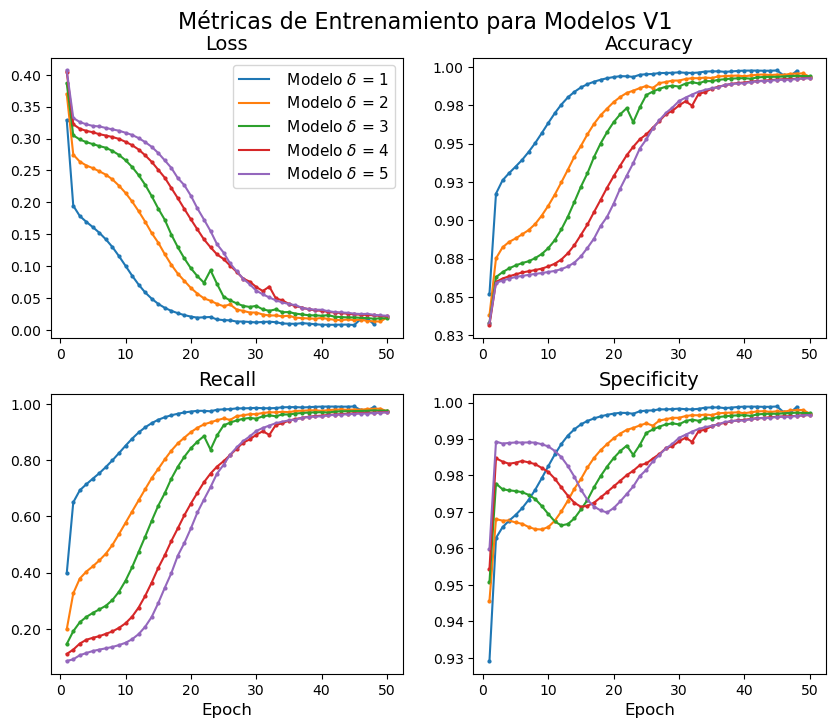

In [11]:
ylabels = ['Loss', 'Accuracy', 'Recall', 'Specificity'] # , 'Accuracy', 'Sensibilidad', 'Precisión', 'F1 Score', 'Especificidad', 'Hamming'
headers = ['loss', 'Accuracy', 'Recall', 'Specificity'] # , 'accuracy', 'recall_m', 'precision_m', 'f1_score_m', 'specificity_m', 'hamming_loss_m'

entrenamiento, ax = plt.subplots(2,2, figsize=(10,8))
ax = ax.flatten()
entrenamiento.suptitle(fr'Métricas de Entrenamiento para Modelos V1', y=0.94,fontsize=16)

ax[2].set_xlabel('Epoch', fontsize=12)
ax[3].set_xlabel('Epoch', fontsize=12)
for k in range(0,4):
    
    ax[k].set_title(f'{ylabels[k]}', fontsize=14)
    ax[k].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    for delta in range(1, 6):
        key = f'historialV1_delta{delta}'
    
        y2 = historiales_delta_s2[key][headers[k]]
        y5 = historiales_delta_s5[key][headers[k]]
        y7 = historiales_delta_s7[key][headers[k]]
        y11 = historiales_delta_s11[key][headers[k]]
        y42 = historiales_delta_s42[key][headers[k]]

        Y = [y2,y5,y7,y11,y42]
        y = list(map(np.mean, zip(*Y)))

        x = np.arange(1, len(y)+1)
        ax[k].plot(x, y, label=f' Modelo $\delta$ = {delta}')
        ax[k].scatter(x, y, s=4)

        # print(headers[k],delta, y)

ax[0].legend(loc='best', fontsize=11)

entrenamiento.savefig(f'../Modelo V1/Gráficas Resultados/Media/entrenamientoV1.png', dpi=300, bbox_inches='tight') 

### Métricas Evaluación

In [14]:
def contador_vecinas_vivas(tablero_inicial, r, c, size=(3,3)):
    
    """ 
    Cuenta el número de células vecinas vivas para la célula (r,c) de un tablero dado.

    Inputs:

        tablero_inicial (2d-nparray): configuración del tablero inicial.
        r (int): fila de la célula a analizar.
        c (int): columna de la célula a analizar.
        size (int,int):  dimensiones de los tableros atendiendo al número de (filas, columnas). Por defecto: (3,3)

    Output:
        vivas (int): número de células vecinas vivas.
        
    """
    max_r, max_c = size
    vivas = 0
    for dr in [-1,0,1]:     # dr: desplazamientos en las filas (-1: mov arriba; 0: no mov; 1: mov abajo)
        for dc in [-1,0,1]: # dc: desplazmientos en columnas (-1: mov izq; 0: no mov; 1: mov dcha)
            
            if dr == 0 and dc == 0: # Estariamos sobre la célula (r,c)
                continue
            nr, nc = r + dr, c + dc

            if 0 <= nr < max_r and 0 <= nc < max_c: # Nos aseguramos que nos encontremos en el tablero
                vivas += tablero_inicial[nr][nc]# Como tablero está formado por 0 y 1, solo suma cuando 1 (viva)
    
    return vivas


def game_of_life(tablero_inicial, size=(3,3), delta=1):

    """ 
    Función para ejecutar el Juego de Conway sobre un tablero inicial, de tamaño size, delta generaciones.

    Inputs:

        tablero_inicial (2d-nparray): matriz de la configuración del tablero inicial.
        size (int,int):  dimensiones de los tableros atendiendo al número de (filas, columnas). Por defecto: (3,3)
        delta (int): número de pasos entre el tablero inicial y final. (Nº de generaciones)
    
    Outputs:

        tablero_GoL (2d-nparray): matriz de la configuración del tablero final. 
        
    """

    max_r, max_c = size

    next_generation = np.zeros(size)
    tablero = tablero_inicial

    for pasos in range(delta): # Repetimos tantas generaciones como se han indicado:

        for r in range(max_r):  # Barremos todas las filas

            for c in range(max_c): # Barremos todas las columnas

                # Contamos las celdas vivas en torno a la célula (r,c)
                vivas = contador_vecinas_vivas(tablero, r, c, size)

                if tablero[r][c] == 1: # la célula (r,c) está viva:

                    if vivas in [2,3]: # Sobrevive
                        next_generation[r][c] = 1

                else: # la célula (r,c) está muerta:

                    if vivas == 3: # Nace
                        next_generation[r][c] = 1
        tablero = next_generation

    tablero_GoL = next_generation

    return  tablero_GoL 

In [15]:
test = pd.read_excel((datos[0]), sheet_name = 'test', header = 0)
stops = [f'stop.{i}' for i in range(1,401)]

Semilla 2, delta 1
Semilla 5, delta 1
Semilla 7, delta 1
Semilla 11, delta 1
Semilla 42, delta 1
Fin de la iteración de las semillas
--------------------------------------
Accuracies: [1.         0.98950005 0.992      ... 0.9745     0.929      0.96450007]
Recalls: [1.         0.95897436 0.9772727  ... 0.9304348  0.82127666 0.8953846 ]
Especificidades: [1.         0.99279773 0.9938202  ... 0.98022604 0.96209157 0.9779104 ]
Fin delta = 1
--------------------------------------
Semilla 2, delta 2
Semilla 5, delta 2
Semilla 7, delta 2
Semilla 11, delta 2
Semilla 42, delta 2
Fin de la iteración de las semillas
--------------------------------------
Accuracies: [0.9615     0.96949995 0.9925     ... 0.80200005 0.98       0.8545    ]
Recalls: [0.6666666  0.4        0.88235295 ... 0.48641977 0.6        0.5058824 ]
Especificidades: [0.9880109  0.9826087  0.997389   ... 0.8821317  0.9897436  0.90544415]
Fin delta = 2
--------------------------------------
Semilla 2, delta 3
Semilla 5, delta 3
Semi

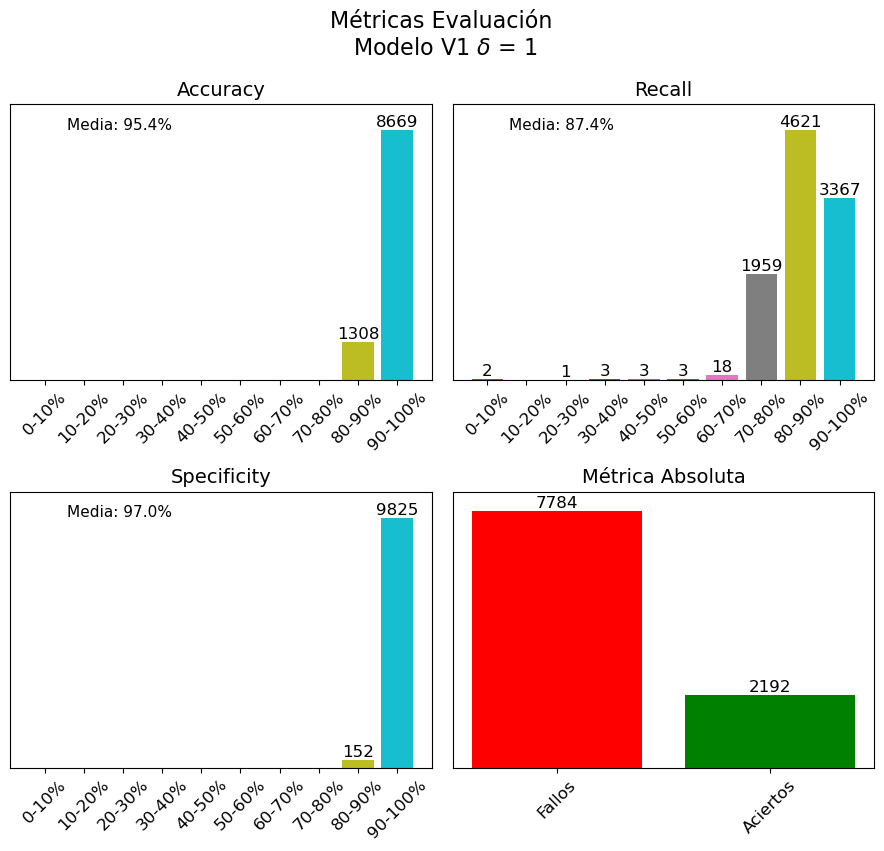

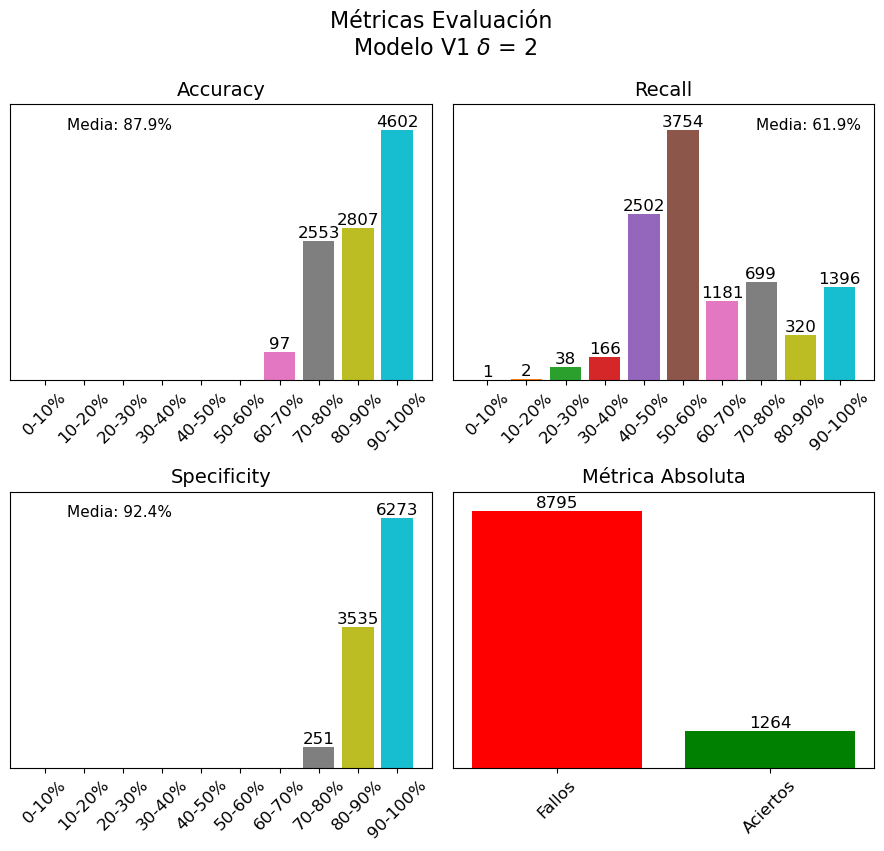

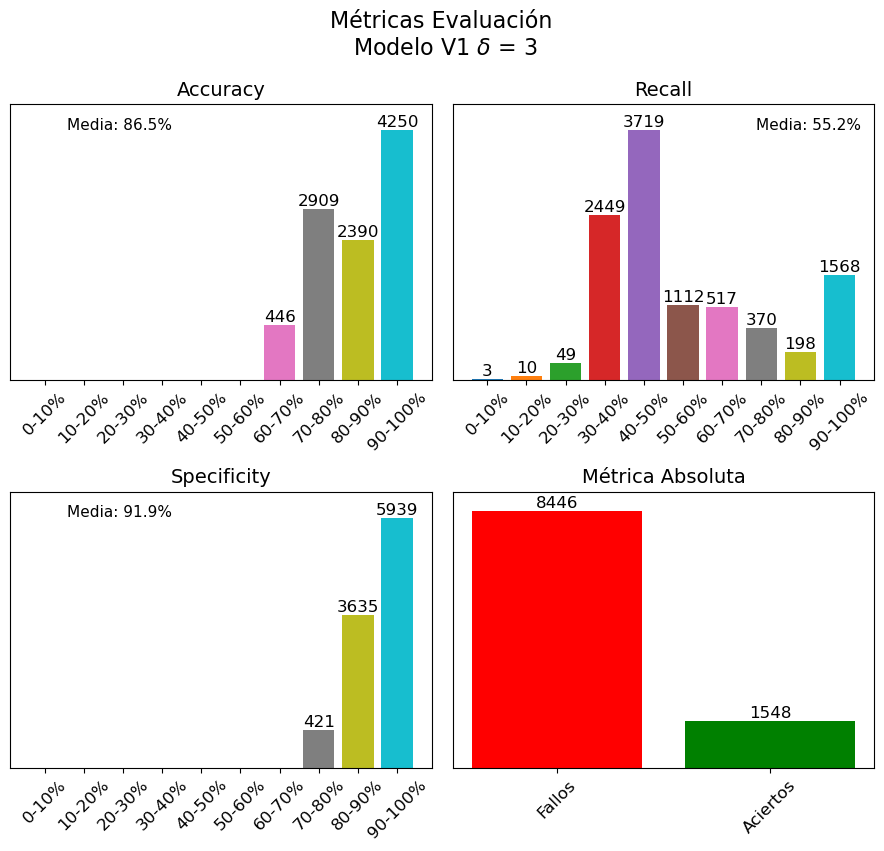

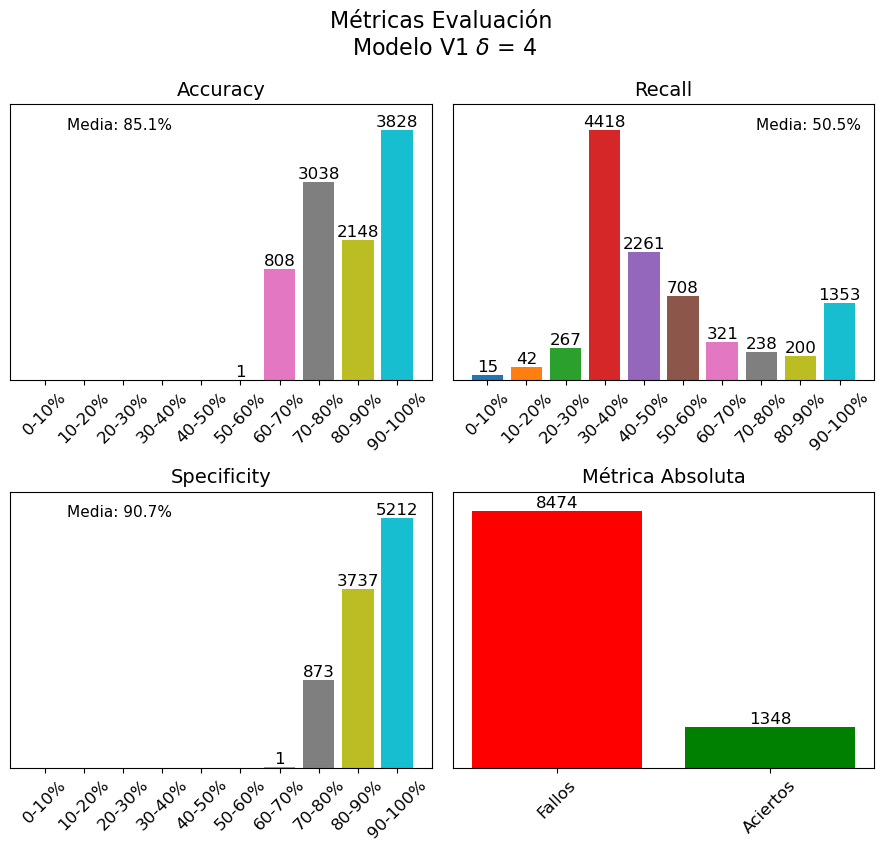

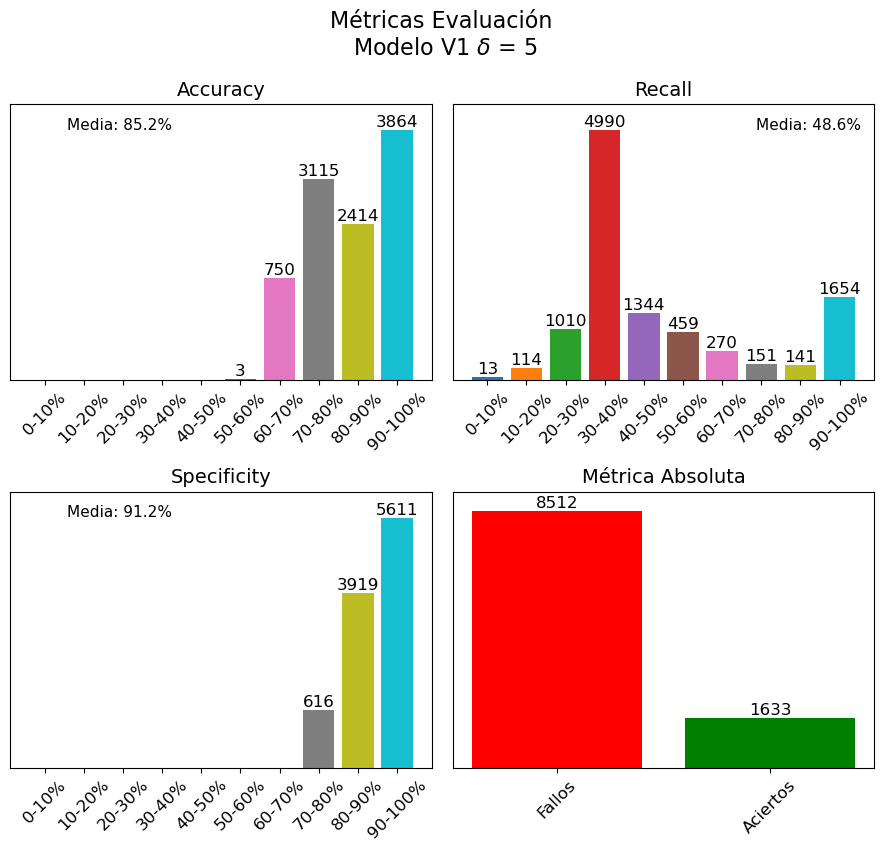

In [ ]:

for delta in range(1,6):

    Accuracies = []
    Recalls = []
    Especificidades = []
    Fallos = []
    Aciertos = []

    for SEED in seeds:
        print(f'Semilla {SEED}, delta {delta}')
        key = f'delta_{delta}'

        df_predicciones = pd.read_excel(f'../Modelo V1/Predicciones/Semilla {SEED}/prediccionesV1.xlsx', sheet_name=key, header=None, skiprows=1)
        numpy_pred = df_predicciones.to_numpy() # shape (n_tableros, 400)
        tableros_iniciales = numpy_pred.reshape(-1,20,20) # shape (n_tableros, 20, 20)
        
        delta_i = test[test['delta'] == delta]
        finales_i = np.reshape(delta_i[stops].values, (-1,20,20), order='F')  # shape (n_tableros_finales, 20,20)
        
        ### Métricas ###
        
        accuracies = []
        recalles = []
        especificidades = []
        absolutos = []

        for tablero_inicial, final_real in zip(tableros_iniciales, finales_i):  # (20x20), (20x20)

            # Hay que usar ravel porque los comandos de las métricas esperan valores, no arrays
            y_pred = game_of_life(tablero_inicial, size=(20,20), delta=1).astype(int).ravel()  # (20x20) => (400,)
            y_true = final_real.astype(int).ravel()  # (20x20) => (400,)

            # Convertir a tensores float32
            y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
            y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)

            # Calcular métricas
            accuracies.append(Accuracy(y_true, y_pred).numpy())
            recalles.append(Recall(y_true, y_pred).numpy())
            especificidades.append(Specificity(y_true, y_pred).numpy())
            absolutos.append(np.array_equal(y_pred, y_true))


        # Conteo fallos y aciertos
    
        fallos = absolutos.count(0)
        aciertos = absolutos.count(1)

        # Guardado de métricas
        Accuracies.append(accuracies)
        Recalls.append(recalles)
        Especificidades.append(especificidades)
        Fallos.append(fallos)
        Aciertos.append(aciertos)

    print('Fin guardado de métricas para las semillas')
    print('--------------------------------------')

    id = np.arange(0, len(tableros_iniciales)) # id de los tableros
    y1 = np.array(list(map(np.mean, zip(*Accuracies))))
    y2 = np.array(list(map(np.mean, zip(*Recalls))))
    y3 = np.array(list(map(np.mean, zip(*Especificidades))))
    y4_1 = int(np.mean(Fallos))
    y4_2 = int(np.mean(Aciertos))

    print(f'Accuracies: {y1}')
    print(f'Recalls: {y2}')
    print(f'Especificidades: {y3}')


    lista = [y1, y2, y3, '']
    metricas = ['Accuracy','Recall',  'Specificity', 'Absoluto']

    xlab = ['Fallos', 'Aciertos']
    barras_conteo = [y4_1, y4_2]
    color_conteo = ['red', 'green']


    # --------------------- GRÁFICO BARRAS ---------------------

    fig, ax = plt.subplots(2, 2, figsize=(9,9))
    ax = ax.flatten()

    x = ['0-10%', '10-20%', '20-30%', '30-40%','40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

    for k in range(len(metricas)):

        
        contados_x_intervalos = []

        if k != len(metricas) - 1:
            ax[k].hlines(np.mean(lista[k])*100, 0,0)
            custom_legend = [Line2D([], [], linestyle='None', marker='', label=f'Media: {np.round(np.mean(lista[k])*100,1)}%')]
            # Agregar la leyenda solo con texto
            ax[k].legend(handles=custom_legend, loc='best', frameon=False, fontsize=11)

            for i in np.arange(0, 1, 0.1):
                x1 = i
                x2 = i + 0.1
                if i == 0.0:
                    contados_x_intervalos.append(np.sum((lista[k] >= x1) & (lista[k] <= x2)))
                else:
                    contados_x_intervalos.append(np.sum((lista[k] > x1) & (lista[k] <= x2)))

            
                    ### Gráficos de Barras ###

            colores = ['#1f77b4',  # azul
                        '#ff7f0e',  # naranja
                        '#2ca02c',  # verde
                        '#d62728',  # rojo
                        '#9467bd',  # morado
                        '#8c564b',  # marrón
                        '#e377c2',  # rosa
                        '#7f7f7f',  # gris
                        '#bcbd22',  # verde amarillento
                        '#17becf']  # azul verdoso
            
            
            for j in range(0, len(contados_x_intervalos)):
                
                real = contados_x_intervalos[j]
                
                y = real/len(id)
                
                if real< 1000:
                    if real == 0:

                        ax[k].bar(x[j], y, color='black')

                    elif real < 100:

                        ax[k].bar(x[j], y*5,color = colores[j])
                        ax[k].annotate(f'{int(contados_x_intervalos[j])}', xy=(x[j], y*5), ha='center', va='bottom', fontsize=12, color='black')
                        
                        
                    else:
                        ax[k].bar(x[j], y*2,color = colores[j])
                        ax[k].annotate(f'{int(contados_x_intervalos[j])}', xy=(x[j], y*2), ha='center', va='bottom', fontsize=12, color='black')
                        
                else:
                    
                    ax[k].bar(x[j],y*0.95, color = colores[j])
                    ax[k].annotate(f'{int(contados_x_intervalos[j])}', xy=(x[j], y*0.95), ha='center', va='bottom', fontsize=12, color='black')
                    

            ax[k].set_yticks([])
            ax[k].set_ylim(0, (max(contados_x_intervalos))/len(id)*1.05)
            ax[k].set_title(f'{metricas[k]}', fontsize=14)
            ax[k].tick_params(axis='x', rotation=45, labelsize=12) 

        else:
            for i in range(2):
                ax[k].bar(x = xlab[i], height = barras_conteo[i], color= color_conteo[i])
                ax[k].annotate(f'{barras_conteo[i]}', xy=(xlab[i], barras_conteo[i]), ha='center', va='bottom', fontsize=12, color='black')
                ax[k].tick_params(axis='x', rotation=45, labelsize=12)  
            ax[k].set_title('Métrica Absoluta', fontsize=14)
            ax[k].set_yticks([])
            ax[k].set_ylim(0, max(barras_conteo)*1.075)

    fig.suptitle('Métricas Evaluación \n' fr'Modelo V1 $\delta$ = {delta}', y = 0.94, fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    fig.savefig(f'../Modelo V1/Gráficas Resultados/Media/barrasV1_delta{delta}.png', dpi=300, bbox_inches='tight')
    print(f'Fin delta = {delta}')
    print('--------------------------------------')
plt.show()
